In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Задание 1

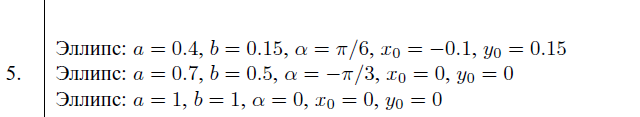

## Инициализация данных

In [196]:
def create_elips(p, a, b, alpha, x0, y0):
    x = a * np.cos(p) + x0
    y = b * np.sin(p) + y0
    x = x * np.cos(alpha) - y * np.sin(alpha)
    y = x * np.sin(alpha) + y * np.cos(alpha)
    return x, y

In [197]:
a_1 = 0.4
b_1 = 0.15
alpha_1 = np.pi / 6
x0_1 = - 0.1
y0_1 = 0.15

a_2 = 0.7
b_2 = 0.5
alpha_2 = - np.pi / 3
x0_2 = 0
y0_2 = 0

a_3 = 1
b_3 = 1
alpha_3 = 0
x0_3 = 0
y0_3 = 0

In [198]:
step = 0.025
points = np.linspace(0, 2*np.pi, int(2*np.pi/step), endpoint=True)

class1_points = np.random.permutation(points)[:60]
class2_points = np.random.permutation(points)[:100]
class3_points = np.random.permutation(points)[:120]

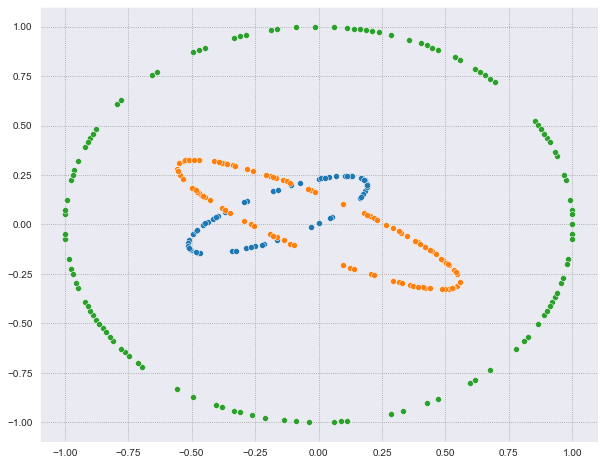

In [200]:
x1, y1 = create_elips(class1_points, a_1, b_1, alpha_1, x0_1, y0_1)
x2, y2 = create_elips(class2_points, a_2, b_2, alpha_2, x0_2, y0_2)
x3, y3 = create_elips(class3_points, a_3, b_3, alpha_3, x0_3, y0_3)

plt.figure(figsize=(10,8))

sns.scatterplot(x = x1, y = y1)
sns.scatterplot(x = x2, y = y2)
sns.scatterplot(x = x3, y = y3)

plt.show()

In [54]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, stratify = y_train)
    return  X_train, X_val, X_test, y_train, y_val, y_test

feature1 = np.concatenate((x1[:, np.newaxis], y1[:, np.newaxis]), axis = 1)
label1 = np.full(len(feature1), 0)

feature2 = np.concatenate((x2[:, np.newaxis], y2[:, np.newaxis]), axis = 1)
label2 = np.full(len(feature2), 1)

feature3 = np.concatenate((x3[:, np.newaxis], y3[:, np.newaxis]), axis = 1)
label3 = np.full(len(feature3), 2)

X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = train_val_test_split(feature1, label1)
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = train_val_test_split(feature2, label2)
X_train3, X_val3, X_test3, y_train3, y_val3, y_test3 = train_val_test_split(feature3, label3)

X_train = torch.tensor(np.concatenate((X_train1, X_train2, X_train3), axis = 0), dtype = torch.float32)
y_train = torch.tensor(np.concatenate((y_train1, y_train2, y_train3), axis = 0), dtype = torch.float32)


X_val = torch.tensor(np.concatenate((X_val1, X_val2, X_val3), axis = 0), dtype = torch.float32)
y_val = torch.tensor(np.concatenate((y_val1, y_val2, y_val3), axis = 0), dtype = torch.float32)

X_test = torch.tensor(np.concatenate((X_test1, X_test2, X_test3), axis = 0), dtype = torch.float32)
y_test = torch.tensor(np.concatenate((y_test1, y_test2, y_test3), axis = 0), dtype = torch.float32)

print('train shape: ', X_train.shape, y_train.shape)
print('val shape: ', X_val.shape, y_val.shape)
print('test shape: ', X_test.shape, y_test.shape)

## Реализация сети

In [203]:
class FeedforwardNet1(torch.nn.Module):
    
        def __init__(self, input_shape, hidden_size):
            super().__init__()
            self.fc1 = nn.Linear(input_shape, hidden_size)
            self.tanh1 = nn.Tanh()
            self.fc2 = nn.Linear(hidden_size, 3)
            self.tanh2 = nn.Tanh()
            
        def forward(self, x):
            x = self.fc1(x)
            x = self.tanh1(x)
            x = self.fc2(x)
            x = self.tanh2(x)
            return x
        
        def fit(self, X_train, y_train, X_val, y_val, optimizer, criterion,  num_epochs, early_stoppong = 1e-5):
            train_losses = []
            valid_losses = []
            y_train = y_train.type(torch.LongTensor)
            y_val = y_val.type(torch.LongTensor)
            for epoch in range(num_epochs): 
                train_loss = 0.0
                valid_loss = 0.0
                
                optimizer.zero_grad()
                y_pred = self.forward(X_train)
                loss = criterion(y_pred, y_train)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() 
                    
                out = self.forward(X_val)
                loss = criterion(out, y_val) 
                valid_loss += loss.item() 
                
                if epoch % 100 == 0 or epoch == num_epochs - 1:
                    print(f'Epoch {epoch} \t Train loss = {train_loss} \t Validation loss = {valid_loss}')
                train_losses.append(train_loss)
                valid_losses.append(valid_loss)
                
                if loss < early_stoppong:
                    break
                    
            return train_losses, valid_losses
            

## Обучение и тест

In [211]:
model = FeedforwardNet1(input_shape= 2, hidden_size= 20)
print(model)

FeedforwardNet1(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (tanh1): Tanh()
  (fc2): Linear(in_features=20, out_features=3, bias=True)
  (tanh2): Tanh()
)


In [212]:
print(f'Initial weights 1st layer: {model.fc1.weight.data}')
print(f'Initial bias 1st layer: {model.fc1.bias.data}')

print(f'Initial weights 2nd layer: {model.fc2.weight.data}')
print(f'Initial bias 2nd layer: {model.fc2.bias.data}')

Initial weights 1st layer: tensor([[-0.3988, -0.2212],
        [-0.0655,  0.0952],
        [-0.0550,  0.6987],
        [-0.5787,  0.4419],
        [-0.0720, -0.5961],
        [ 0.7046, -0.1379],
        [-0.5271,  0.2926],
        [ 0.6835, -0.4317],
        [-0.0657,  0.6500],
        [ 0.6574,  0.5961],
        [ 0.1733,  0.1353],
        [-0.3386,  0.4447],
        [-0.0504,  0.0296],
        [ 0.4083,  0.0878],
        [-0.4131,  0.2497],
        [-0.4187, -0.2775],
        [ 0.1738, -0.2743],
        [ 0.2403,  0.2752],
        [-0.6737, -0.6879],
        [ 0.3434, -0.3214]])
Initial bias 1st layer: tensor([ 0.2385, -0.3716, -0.2002, -0.1869, -0.0953, -0.0548, -0.5521,  0.1639,
        -0.4844, -0.0897,  0.0726, -0.1219, -0.4939,  0.1228, -0.1560,  0.6952,
         0.6187,  0.2322, -0.4621, -0.4167])
Initial weights 2nd layer: tensor([[-0.1133, -0.0921, -0.0041, -0.0195,  0.1770, -0.1366,  0.0466, -0.0680,
          0.0541,  0.1228, -0.0909, -0.0050, -0.1779, -0.1536,  0.1287, -0.

Adam лучше Rprop

In [213]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Rprop(model.parameters(), lr = 0.01)

In [214]:
tain_loss, val_loss = model.fit(X_train, y_train, X_val, y_val, optimizer, criterion,  num_epochs = 500)

Epoch 0 	 Train loss = 1.1142897605895996 	 Validation loss = 1.0966167449951172
Epoch 100 	 Train loss = 0.2987919747829437 	 Validation loss = 0.3025567829608917
Epoch 200 	 Train loss = 0.28814610838890076 	 Validation loss = 0.29615336656570435
Epoch 300 	 Train loss = 0.28468969464302063 	 Validation loss = 0.29632750153541565
Epoch 400 	 Train loss = 0.2829989492893219 	 Validation loss = 0.29662737250328064
Epoch 499 	 Train loss = 0.27984419465065 	 Validation loss = 0.3182925879955292


In [215]:
print(f'Result weights 1st layer: {model.fc1.weight.data}')
print(f'Result bias 1st layer: {model.fc1.bias.data}')

print(f'Result weights 2nd layer: {model.fc2.weight.data}')
print(f'Result bias 2nd layer: {model.fc2.bias.data}')

Result weights 1st layer: tensor([[-5.4304e+00, -6.4988e+00],
        [-2.8927e-02,  4.9313e-02],
        [-7.2116e+00,  1.7411e+01],
        [ 5.2626e-02,  7.1156e-01],
        [-1.1924e-01,  1.4511e-01],
        [ 6.0821e+00, -6.9837e-01],
        [-4.6226e+00,  6.1977e+00],
        [ 8.3002e-01, -1.5784e-01],
        [-7.0475e-01,  2.2173e+00],
        [ 8.4245e+00,  8.2558e+00],
        [ 1.6637e-01, -4.8645e-02],
        [ 5.9367e+00,  6.3643e+01],
        [ 1.6892e+00,  9.3788e+00],
        [ 5.6411e-02,  7.3432e-02],
        [-1.3958e-01,  2.1106e-01],
        [ 6.0596e-02, -2.8522e-02],
        [-6.8178e-01, -6.2850e+00],
        [ 7.5659e+00,  1.4966e+01],
        [-4.3460e+00, -2.7469e+00],
        [-6.8695e-02, -3.6949e-02]])
Result bias 1st layer: tensor([ 0.7670, -9.5233,  0.0626, 10.0127, -0.2920, -3.2339, -2.0432,  0.1438,
        -1.7510,  2.2805, 10.7300, -0.8371, -1.6427,  9.1369, -1.8164,  9.4106,
         1.1580,  1.2085, -1.0054, -9.3496])
Result weights 2nd layer:

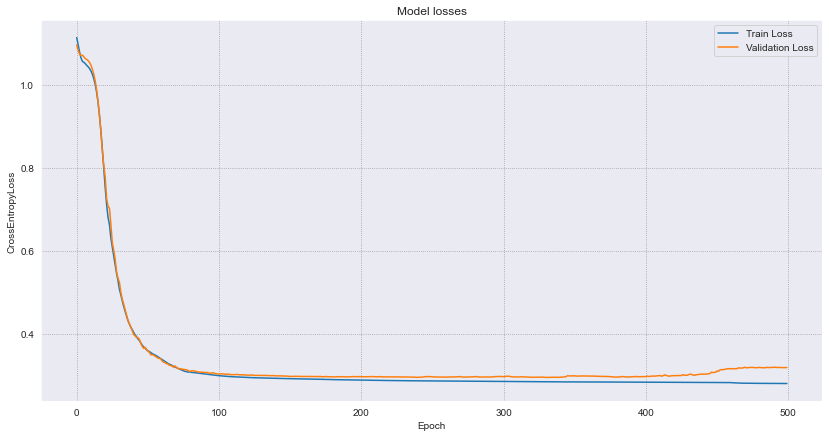

In [218]:
plt.figure(figsize=(14,7))

plt.title('Model losses')

sns.lineplot(x = range(500), y = tain_loss)
sns.lineplot(x = range(500), y = val_loss)

plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('CrossEntropyLoss')

plt.show()

In [219]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
    outputs = model.forward(X_train)
    _, y_test_pred = torch.max(outputs.data, 1)     
    
print(f'Train Accuracy of the model: {accuracy_score(y_train.detach().numpy(), y_test_pred.detach().numpy())} %')

Train Accuracy of the model: 0.9285714285714286 %


In [220]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
    outputs = model.forward(X_val)
    _, y_val_pred = torch.max(outputs.data, 1)     
    
print(f'Validation Accuracy of the model: {accuracy_score(y_val.detach().numpy(), y_val_pred.detach().numpy())} %')

Validation Accuracy of the model: 0.9285714285714286 %


In [221]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
    outputs = model.forward(X_test)
    _, y_pred = torch.max(outputs.data, 1)     
    
print(f'Test Accuracy of the model: {accuracy_score(y_test.detach().numpy(), y_pred.detach().numpy())} %')

Test Accuracy of the model: 0.8928571428571429 %


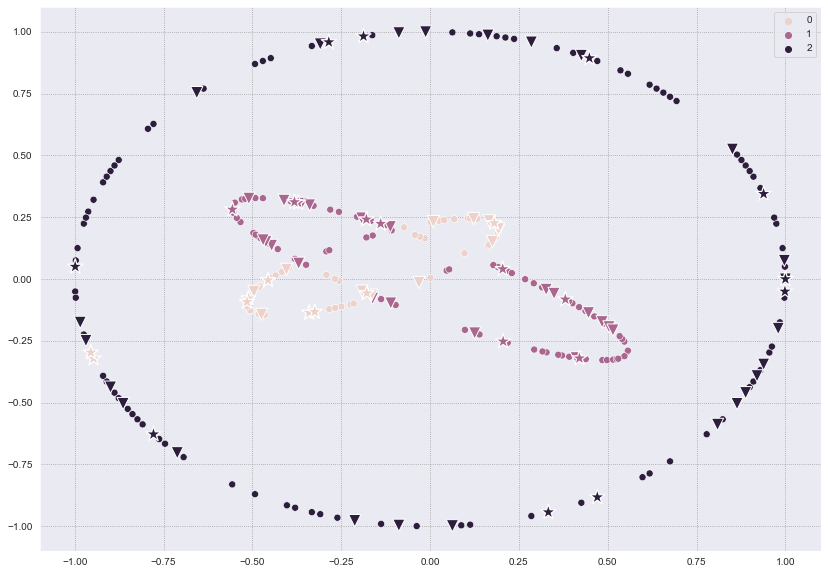

In [222]:
plt.figure(figsize=(14,10))
sns.scatterplot(x = X_train[:,0], y = X_train[:,1], hue=y_test_pred.detach().numpy(), s=50)
sns.scatterplot(x = X_val[:,0], y = X_val[:,1], hue=y_val_pred.detach().numpy(), marker = 'v', s=150, legend = False)
sns.scatterplot(x = X_test[:,0], y = X_test[:,1], hue=y_pred.detach().numpy(), marker = '*', s=250, legend= False)
plt.show()

In [223]:
def plot_decision_bounds(model):
    plt.figure(figsize=(14,10))

    x_min, x_max = -1, 1
    y_min, y_max = -1, 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
    out = model.forward(torch.tensor(np.concatenate((xx.ravel()[:,np.newaxis], yy.ravel()[:,np.newaxis]), axis = 1), dtype=torch.float32))
    _, Z = torch.max(out, 1)
    Z = Z.detach().numpy()
    
    sns.scatterplot(x = xx.ravel(), y = yy.ravel(), c = Z, cmap= 'Set2')
    plt.xlim((x_min, x_max))
    plt.ylim((y_min, y_max))

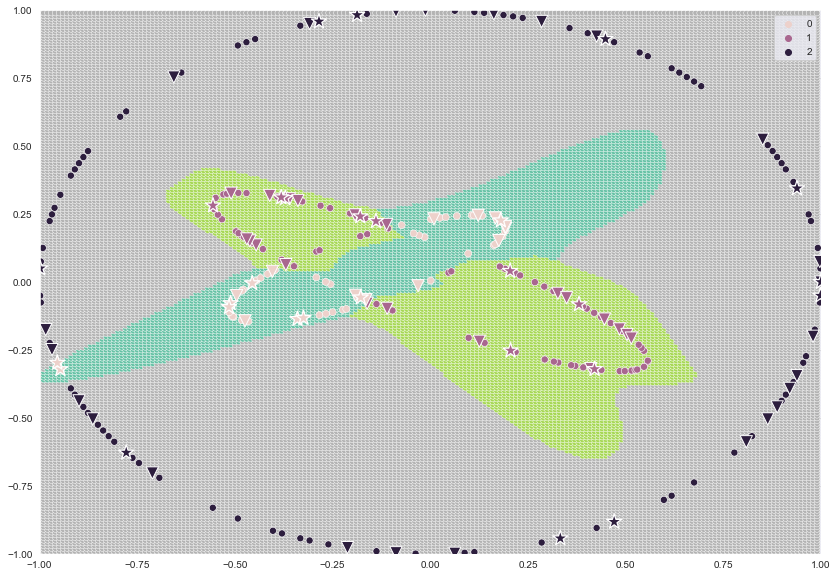

In [224]:
plot_decision_bounds(model)
sns.scatterplot(x = X_train[:,0], y = X_train[:,1], hue=y_test_pred.detach().numpy(), s=50)
sns.scatterplot(x = X_val[:,0], y = X_val[:,1], hue=y_val_pred.detach().numpy(), marker = 'v', s=150, legend = False)
sns.scatterplot(x = X_test[:,0], y = X_test[:,1], hue=y_pred.detach().numpy(), marker = '*', s=250, legend= False)
plt.show()

# Задание 2

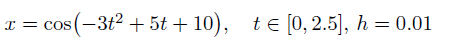

## Инициализация данных

In [2]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def sko(y_true, y_pred):
    rmse = r2_score(y_true, y_pred)
    return (rmse / (y_true.max() - y_true.min())) * 100


def min_max_error(y_true, y_pred):
    diff = abs(y_true - y_pred)
    return diff.min(), diff.max()


def fraction_error(y_true, y_pred):
    return (abs(y_true - y_pred)) / y_true * 100

In [3]:
def f(x):
    return np.cos( -3 * x ** 2 + 5 * x + 10)

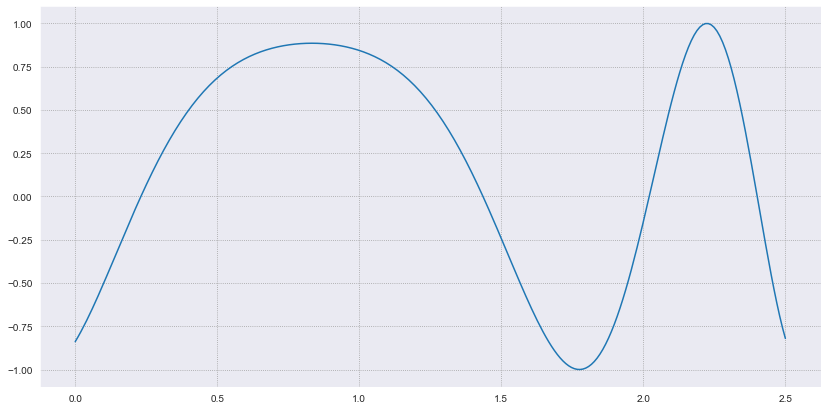

In [4]:
h = 0.01
X = np.linspace(0, 2.5, int(2.5/0.01), endpoint=True)
y = f(X)

plt.figure(figsize=(14,7))
sns.lineplot(x = X,  y = y)
plt.show()

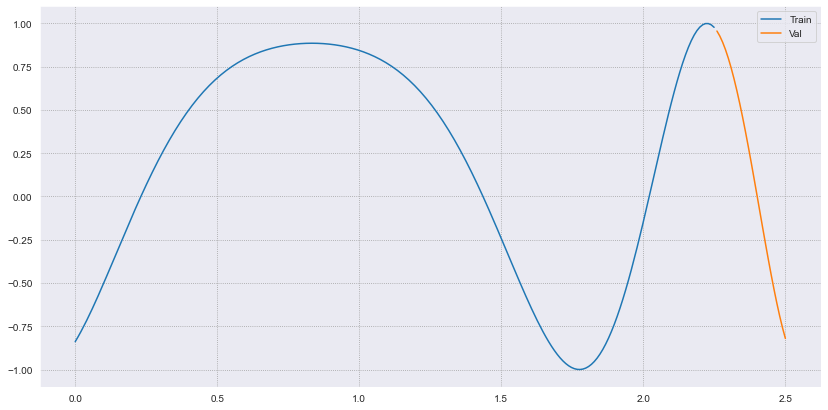

In [5]:
X = X[:,np.newaxis]
X_train = X[:int(0.9 * len(X))]
y_train = y[:int(0.9 * len(y))]
X_val = X[int(0.9 * len(X)):]
y_val = y[int(0.9 * len(y)):]

plt.figure(figsize=(14,7))
sns.lineplot(x = X_train[:,0],  y = y_train)
sns.lineplot(x = X_val[:,0],  y = y_val)
plt.legend(['Train', 'Val'])
plt.show()

In [6]:
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)

In [7]:
print('train shape: ', X_train.shape, y_train.shape)
print('val shape: ', X_val.shape, y_val.shape)

train shape:  torch.Size([225, 1]) torch.Size([225])
val shape:  torch.Size([25, 1]) torch.Size([25])


## Реализация сети

In [17]:
class FeedforwardNet2(torch.nn.Module):
    
        def __init__(self, input_shape, hidden_size):
            super().__init__()
            self.fc1 = nn.Linear(input_shape, hidden_size)
            self.tanh = nn.Tanh()
            self.fc2 = nn.Linear(hidden_size, 1)
            
        def forward(self, x):
            x = self.fc1(x)
            x = self.tanh(x)
            x = self.fc2(x)
            return x
        
        def fit(self, X_train, y_train, X_val, y_val, optimizer, criterion,  num_epochs, early_stoppong = 1e-5, verbose = 100):
            train_losses = []
            valid_losses = []
            for epoch in range(num_epochs): 
                train_loss = 0.0
                valid_loss = 0.0
                
                def closure():
                    optimizer.zero_grad()
                    y_pred = self.forward(X_train)
                    loss = criterion(torch.flatten(y_pred), y_train)
                    loss.backward() 
                    return loss
                
                y_pred = self.forward(X_train)
                loss = criterion(torch.flatten(y_pred), y_train)
                optimizer.step(closure)
                train_loss += loss.item()
                    
                out = self.forward(X_val)
                loss = criterion(torch.flatten(out), y_val) 
                valid_loss += loss.item() 
                
                if epoch % verbose == 0 or epoch == num_epochs - 1:
                    print(f'Epoch {epoch} \t Train loss = {train_loss} \t Validation loss = {valid_loss}')
                train_losses.append(train_loss)
                valid_losses.append(valid_loss)
                
                if loss < early_stoppong:
                    break
                    
            return train_losses, valid_losses

## Обучение и тест

In [18]:
model = FeedforwardNet2(input_shape= 1, hidden_size= 30)

In [19]:
print(f'Initial weights 1st layer: {model.fc1.weight.data}')
print(f'Initial bias 1st layer: {model.fc1.bias.data}')

print(f'Initial weights 2nd layer: {model.fc2.weight.data}')
print(f'Initial bias 2nd layer: {model.fc2.bias.data}')

Initial weights 1st layer: tensor([[ 0.0098],
        [-0.3221],
        [ 0.2913],
        [-0.0994],
        [ 0.4283],
        [ 0.3589],
        [ 0.1727],
        [ 0.2570],
        [ 0.9878],
        [ 0.5454],
        [ 0.5912],
        [-0.1401],
        [ 0.4261],
        [-0.7815],
        [ 0.3011],
        [ 0.8476],
        [ 0.1207],
        [ 0.9285],
        [-0.8073],
        [-0.4725],
        [-0.0973],
        [-0.4278],
        [-0.2904],
        [-0.1900],
        [-0.6251],
        [-0.6708],
        [-0.2666],
        [ 0.6063],
        [ 0.7202],
        [-0.0618]])
Initial bias 1st layer: tensor([ 0.2459,  0.9726, -0.7495,  0.3830, -0.4775, -0.7612,  0.8880, -0.2489,
        -0.5482, -0.6978, -0.7122, -0.8243,  0.4956,  0.9373,  0.5259,  0.5320,
        -0.1806, -0.2203, -0.7116, -0.0530,  0.8303, -0.7493,  0.6616, -0.5447,
        -0.2813, -0.1253, -0.0825,  0.1990,  0.7944, -0.0039])
Initial weights 2nd layer: tensor([[-0.1167,  0.1354,  0.1329, -0.0698,  0.

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.3)

In [21]:
tain_loss, val_loss = model.fit(X_train, y_train, X_val, y_val, optimizer, criterion,  num_epochs = 5000, verbose=250)

Epoch 0 	 Train loss = 0.514107882976532 	 Validation loss = 0.49573054909706116
Epoch 250 	 Train loss = 0.18620795011520386 	 Validation loss = 0.4247162938117981
Epoch 500 	 Train loss = 0.1220376268029213 	 Validation loss = 0.4713848829269409
Epoch 750 	 Train loss = 0.09397413581609726 	 Validation loss = 0.6123538017272949
Epoch 1000 	 Train loss = 0.06049887090921402 	 Validation loss = 0.9661206603050232
Epoch 1250 	 Train loss = 0.041055142879486084 	 Validation loss = 1.3905436992645264
Epoch 1500 	 Train loss = 0.03932230919599533 	 Validation loss = 1.4085241556167603
Epoch 1750 	 Train loss = 0.024816831573843956 	 Validation loss = 1.8506646156311035
Epoch 2000 	 Train loss = 0.016989238560199738 	 Validation loss = 2.2826099395751953
Epoch 2250 	 Train loss = 0.01220401469618082 	 Validation loss = 2.6544189453125
Epoch 2500 	 Train loss = 0.3236778974533081 	 Validation loss = 1.3233298063278198
Epoch 2750 	 Train loss = 0.010141108185052872 	 Validation loss = 2.78537

In [22]:
print(f'Result weights 1st layer: {model.fc1.weight.data}')
print(f'Result bias 1st layer: {model.fc1.bias.data}')

print(f'Result weights 2nd layer: {model.fc2.weight.data}')
print(f'Result bias 2nd layer: {model.fc2.bias.data}')

Result weights 1st layer: tensor([[-0.4295],
        [-1.4719],
        [ 1.2708],
        [-0.5426],
        [ 0.6623],
        [ 1.0353],
        [-0.5620],
        [ 0.4185],
        [ 2.2352],
        [ 0.7298],
        [ 2.1719],
        [ 0.7225],
        [ 0.1614],
        [-3.6617],
        [-0.0633],
        [ 0.2722],
        [ 0.2926],
        [ 1.2977],
        [-0.2618],
        [-0.3649],
        [-0.9070],
        [ 0.1070],
        [-0.9673],
        [ 0.5036],
        [-0.2979],
        [-0.3368],
        [-0.3279],
        [ 0.3086],
        [ 0.2306],
        [ 0.0299]])
Result bias 1st layer: tensor([ 0.5055,  2.9894, -2.5471,  0.7180, -0.9775, -1.9716,  0.7598, -0.4870,
         0.2613, -1.1408, -2.1413, -1.1228, -0.0972,  5.6462,  0.0884, -0.0840,
        -0.2967, -0.0334, -0.1758,  0.3954,  1.6213, -0.1896,  1.7888, -0.6424,
         0.2841,  0.3523,  0.3381, -0.3073,  0.2562, -0.0260])
Result weights 2nd layer: tensor([[-0.1868, -1.3349,  1.0222, -0.2269,  0.282

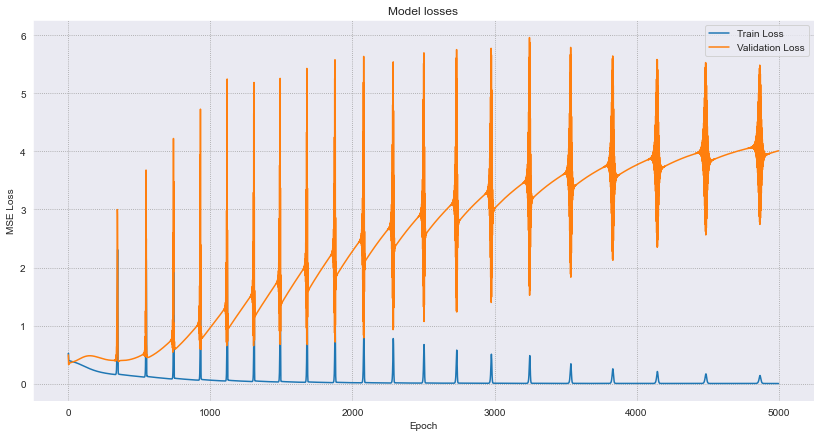

In [23]:
plt.figure(figsize=(14,7))
plt.title('Model losses')

sns.lineplot(x = range(5000), y = tain_loss)
sns.lineplot(x = range(5000), y = val_loss)

plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

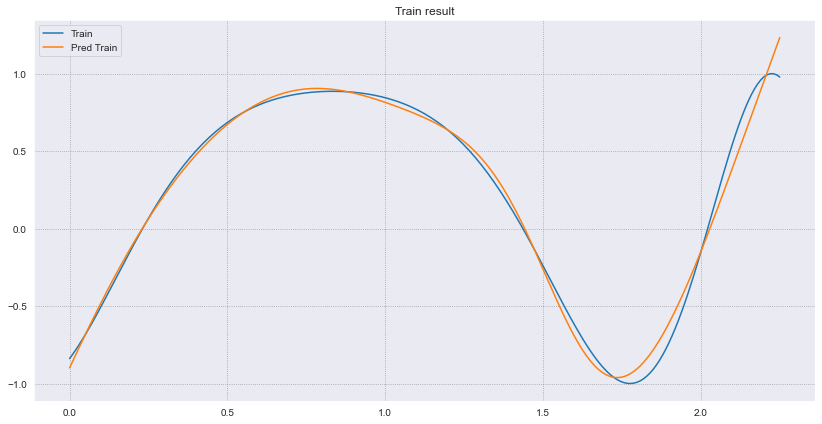

In [24]:
plt.figure(figsize=(14,7))
plt.title('Train result')

sns.lineplot(x = X_train[:,0],  y = y_train)
sns.lineplot(x = X_train[:,0],  y = model.forward(X_train).detach().numpy().reshape(-1))

plt.legend(['Train', 'Pred Train'])
plt.show()

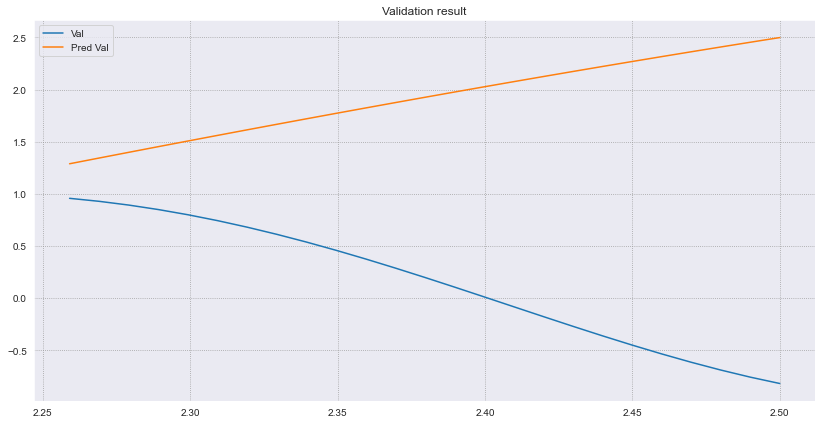

In [25]:
plt.figure(figsize=(14,7))
plt.title('Validation result')

sns.lineplot(x = X_val[:,0],  y = y_val)
sns.lineplot(x = X_val[:,0],  y = model.forward(X_val).detach().numpy().reshape(-1))

plt.legend(['Val', 'Pred Val'])
plt.show()

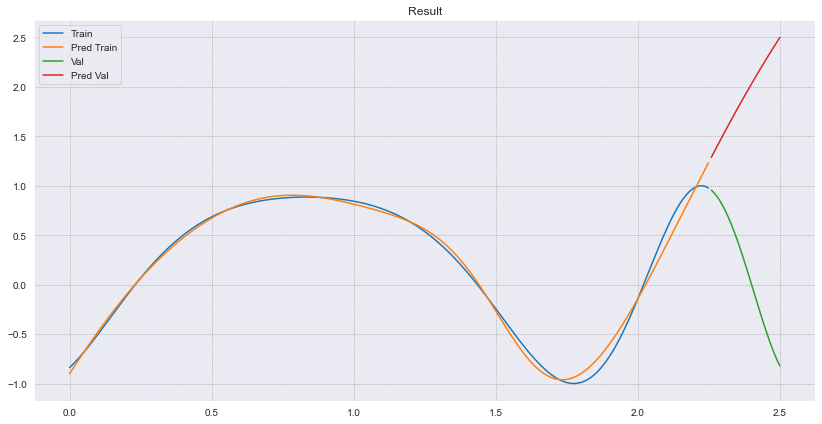

In [26]:
plt.figure(figsize=(14,7))
plt.title('Result')

sns.lineplot(x = X_train[:,0],  y = y_train)
sns.lineplot(x = X_train[:,0],  y = model.forward(X_train).detach().numpy().reshape(-1))
sns.lineplot(x = X_val[:,0],  y = y_val)
sns.lineplot(x = X_val[:,0],  y = model.forward(X_val).detach().numpy().reshape(-1))

plt.legend(['Train', 'Pred Train', 'Val', 'Pred Val'])
plt.show()

In [38]:
y_true = y_train.detach().numpy().reshape(-1)
y_pred = model.forward(X_train).detach().numpy().reshape(-1)

print(f'R2_score = {r2_score(y_true, y_pred)}')

print(f'MSE = {mean_squared_error(y_true, y_pred)}')

print(f'RMSE = {np.sqrt(mean_squared_error(y_true, y_pred))}')

print(f'Относительная СКО = {sko(y_true, y_pred)} %')

print(f'MAE = {mean_absolute_error(y_true, y_pred)}')

min_err, max_err = min_max_error(y_true, y_pred)
print(f'Min absolute error = {min_err}')
print(f'Max absolute error = {max_err}')

print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')

frac = fraction_error(y_true, y_pred)
print(f'Доля с ошибкой менее 5% = {len(frac[frac <= 5]) / len(frac) * 100} %')
print(f'Доля с ошибкой 5 - 10 % = {len(frac[(frac > 5) & (frac <= 10)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 10 - 20 % = {len(frac[(frac > 10) & (frac <= 20)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 20 - 30 % = {len(frac[(frac > 20) & (frac <= 30)]) / len(frac) * 100} %')
print(f'Доля с ошибкой более 30 % = {len(frac[frac > 30]) / len(frac) * 100} %')

R2_score = 0.9915844238700391
MSE = 0.0035147976595908403
RMSE = 0.0592857301235199
Относительная СКО = 49.6023175943021 %
MAE = 0.04177284240722656
Min absolute error = 0.00034427642822265625
Max absolute error = 0.2546476125717163
MAPE = 0.22858479619026184
Доля с ошибкой менее 5% = 76.44444444444444 %
Доля с ошибкой 5 - 10 % = 9.333333333333334 %
Доля с ошибкой 10 - 20 % = 5.333333333333334 %
Доля с ошибкой 20 - 30 % = 4.0 %
Доля с ошибкой более 30 % = 4.888888888888889 %


# Задание 3

## Обучение и тест

In [43]:
model = FeedforwardNet2(input_shape= 1, hidden_size= 20)

In [44]:
print(f'Initial weights 1st layer: {model.fc1.weight.data}')
print(f'Initial bias 1st layer: {model.fc1.bias.data}')

print(f'Initial weights 2nd layer: {model.fc2.weight.data}')
print(f'Initial bias 2nd layer: {model.fc2.bias.data}')

Initial weights 1st layer: tensor([[-0.5453],
        [-0.9965],
        [-0.4769],
        [ 0.9977],
        [-0.2246],
        [-0.2631],
        [-0.5007],
        [ 0.2033],
        [ 0.3612],
        [ 0.4295],
        [-0.3369],
        [ 0.8223],
        [ 0.9701],
        [-0.0306],
        [-0.8818],
        [ 0.8497],
        [-0.8895],
        [-0.2774],
        [ 0.7393],
        [-0.5322]])
Initial bias 1st layer: tensor([-0.0134, -0.7640,  0.2662, -0.9090,  0.3109, -0.1169, -0.7315, -0.8157,
        -0.2060, -0.1977, -0.2973,  0.7439, -0.6144,  0.2761,  0.8162,  0.4168,
         0.5713, -0.2366,  0.5022,  0.7416])
Initial weights 2nd layer: tensor([[ 1.5342e-01,  1.8965e-01,  1.5250e-03, -1.3814e-01, -1.7580e-01,
          1.2162e-01, -8.6256e-02,  1.6542e-01, -1.7709e-01,  1.4395e-04,
         -4.7573e-02,  5.6619e-02, -2.9698e-02, -1.1669e-01,  9.5957e-02,
         -1.4587e-01,  1.7889e-01, -1.1961e-01, -1.5613e-01,  1.9723e-01]])
Initial bias 2nd layer: tensor([-0.145

In [45]:
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr = 0.01)

In [46]:
tain_loss, val_loss = model.fit(X_train, y_train, X_val, y_val, optimizer, criterion,  num_epochs = 200, verbose= 50)

Epoch 0 	 Train loss = 1.299767017364502 	 Validation loss = 1.48997163772583
Epoch 50 	 Train loss = 0.0027022664435207844 	 Validation loss = 4.219387054443359
Epoch 100 	 Train loss = 0.00012311276805121452 	 Validation loss = 0.6927884817123413
Epoch 150 	 Train loss = 3.0896106181899086e-05 	 Validation loss = 0.23222485184669495
Epoch 199 	 Train loss = 2.4818527890602127e-05 	 Validation loss = 0.16227315366268158


In [47]:
print(f'Result weights 1st layer: {model.fc1.weight.data}')
print(f'Result bias 1st layer: {model.fc1.bias.data}')

print(f'Result weights 2nd layer: {model.fc2.weight.data}')
print(f'Result bias 2nd layer: {model.fc2.bias.data}')

Result weights 1st layer: tensor([[ 0.8183],
        [-0.5103],
        [-1.9176],
        [ 2.4872],
        [-1.8673],
        [-0.7337],
        [-0.5199],
        [-0.4061],
        [-0.4506],
        [ 1.6638],
        [-1.0059],
        [ 1.2171],
        [ 2.3653],
        [-0.0352],
        [-1.1923],
        [-0.5652],
        [-3.4891],
        [-1.1376],
        [ 0.0466],
        [-4.1825]])
Result bias 1st layer: tensor([-9.9727e-01, -1.8062e+00, -2.6267e-03, -5.7190e+00,  2.0159e+00,
        -6.9280e-01,  5.4327e-01, -1.9305e+00,  6.6605e-01, -3.7115e-01,
         2.6751e-01, -1.1064e-01,  2.8260e+00,  9.6122e-01,  2.0324e+00,
         5.7387e-01,  7.1662e+00,  9.7825e-01,  1.1011e+00, -1.1089e+00])
Result weights 2nd layer: tensor([[-3.0045,  0.0432, -2.4790, -2.9812, -3.0485, -0.4092,  1.7061,  2.4857,
          1.4881,  1.9695,  0.1618,  0.1038,  4.6106, -0.4970,  2.4767,  2.6729,
         -5.2298,  0.2780,  0.7245,  1.0276]])
Result bias 2nd layer: tensor([-4.7658])


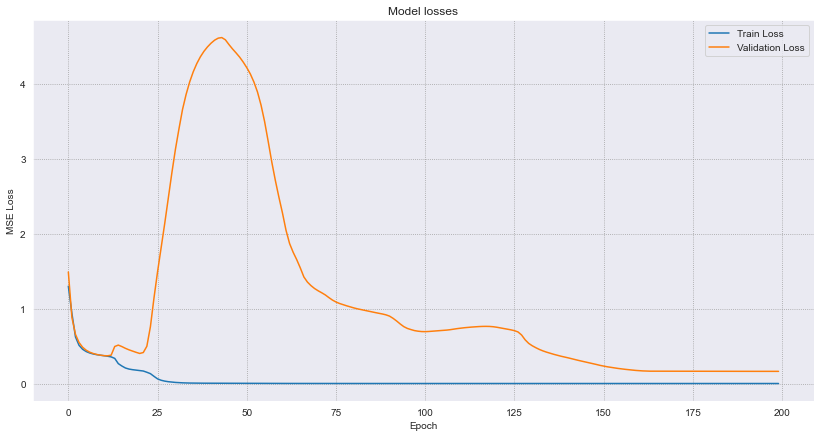

In [48]:
plt.figure(figsize=(14,7))
plt.title('Model losses')

sns.lineplot(x = range(200), y = tain_loss)
sns.lineplot(x = range(200), y = val_loss)

plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

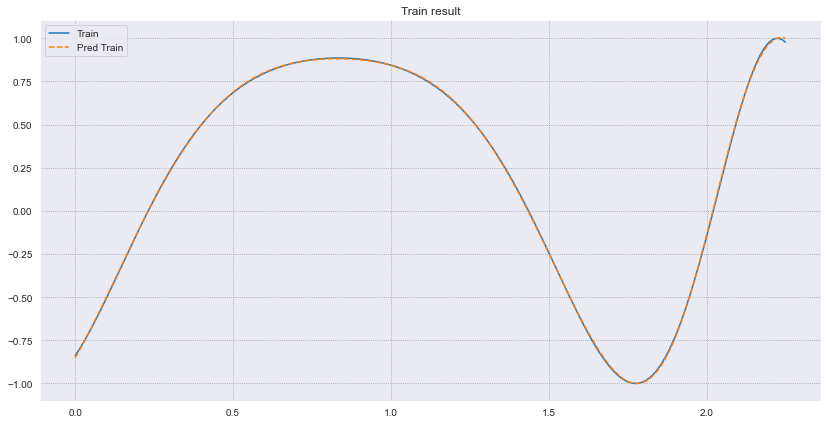

In [49]:
plt.figure(figsize=(14,7))
plt.title('Train result')

sns.lineplot(x = X_train[:,0],  y = y_train)
sns.lineplot(x = X_train[:,0],  y = model.forward(X_train).detach().numpy().reshape(-1), linestyle='--')

plt.legend(['Train', 'Pred Train'])
plt.show()

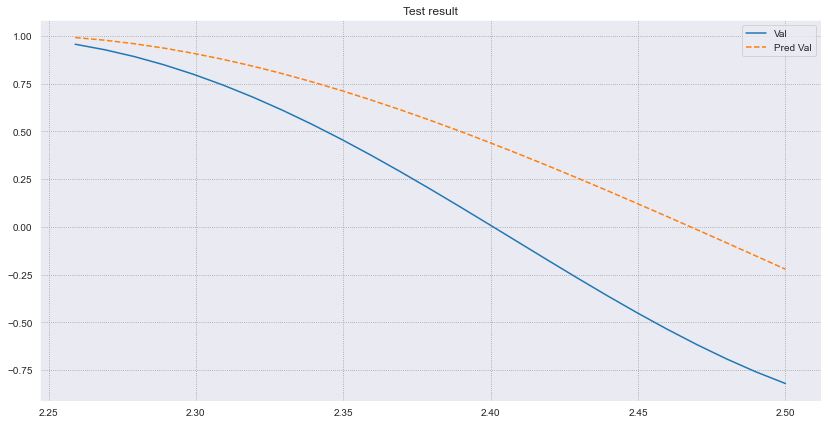

In [50]:
plt.figure(figsize=(14,7))
plt.title('Test result')

sns.lineplot(x = X_val[:,0],  y = y_val)
sns.lineplot(x = X_val[:,0],  y = model.forward(X_val).detach().numpy().reshape(-1), linestyle='--')

plt.legend(['Val', 'Pred Val'])
plt.show()

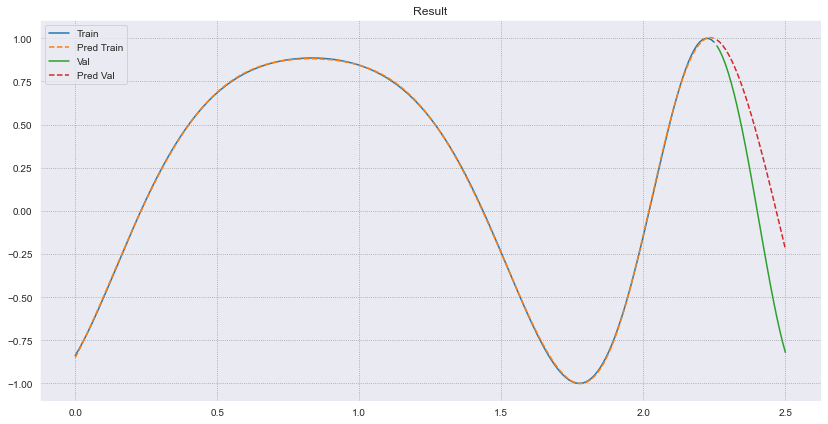

In [51]:
plt.figure(figsize=(14,7))
plt.title('Result')

sns.lineplot(x = X_train[:,0],  y = y_train)
sns.lineplot(x = X_train[:,0],  y = model.forward(X_train).detach().numpy().reshape(-1), linestyle='--')
sns.lineplot(x = X_val[:,0],  y = y_val)
sns.lineplot(x = X_val[:,0],  y = model.forward(X_val).detach().numpy().reshape(-1), linestyle='--')

plt.legend(['Train', 'Pred Train', 'Val', 'Pred Val'])
plt.show()

In [52]:
y_true = y_train.detach().numpy().reshape(-1)
y_pred = model.forward(X_train).detach().numpy().reshape(-1)

print(f'R2_score = {r2_score(y_true, y_pred)}')

print(f'MSE = {mean_squared_error(y_true, y_pred)}')

print(f'RMSE = {np.sqrt(mean_squared_error(y_true, y_pred))}')

print(f'Относительная СКО = {sko(y_true, y_pred)} %')

print(f'MAE = {mean_absolute_error(y_true, y_pred)}')

min_err, max_err = min_max_error(y_true, y_pred)
print(f'Min absolute error = {min_err}')
print(f'Max absolute error = {max_err}')

print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')

frac = fraction_error(y_true, y_pred)
print(f'Доля с ошибкой менее 5% = {len(frac[frac <= 5]) / len(frac) * 100} %')
print(f'Доля с ошибкой 5 - 10 % = {len(frac[(frac > 5) & (frac <= 10)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 10 - 20 % = {len(frac[(frac > 10) & (frac <= 20)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 20 - 30 % = {len(frac[(frac > 20) & (frac <= 30)]) / len(frac) * 100} %')
print(f'Доля с ошибкой более 30 % = {len(frac[frac > 30]) / len(frac) * 100} %')

R2_score = 0.9999405804084793
MSE = 2.48168216785416e-05
RMSE = 0.00498164864256978
Относительная СКО = 50.02032005633124 %
MAE = 0.0041268025524914265
Min absolute error = 9.78708267211914e-05
Max absolute error = 0.022275924682617188
MAPE = 0.054093893617391586
Доля с ошибкой менее 5% = 96.88888888888889 %
Доля с ошибкой 5 - 10 % = 2.2222222222222223 %
Доля с ошибкой 10 - 20 % = 0.8888888888888888 %
Доля с ошибкой 20 - 30 % = 0.0 %
Доля с ошибкой более 30 % = 0.0 %
